# Motivation Figures: MATH Baseline Arrival Rate Sweep

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'figure.figsize': (10, 6),
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'legend.fontsize': 11,
})

# ── Load data ──
DATA_PATH = Path('../logs/motivation_plot_generator_data/baseline_motivation_sweep_math_test_300_poisson.csv')
if not DATA_PATH.exists():
    DATA_PATH = Path('logs/motivation_plot_generator_data/baseline_motivation_sweep_math_test_temp.csv')
df = pd.read_csv(DATA_PATH)

# ── Filter to step-level records (per-LLM-call metrics) ──
step_df = df[df.record_type == 'step'].copy()
ep_df   = df[df.record_type == 'episode'].copy()

# ── Numeric coercion ──
for col in ['latency_seconds', 'arrival_rate', 'llm_running', 'llm_waiting',
            'llm_kv_cache_usage', 'observed_ttft', 'observed_tpot',
            'llm_ttft_avg', 'llm_itl_avg', 'llm_e2e_avg', 'llm_queue_avg', 'llm_inference_avg']:
    step_df[col] = pd.to_numeric(step_df[col], errors='coerce')

# ── Queue depth = running + waiting ──
step_df['queue_depth'] = step_df['llm_running'].fillna(0) + step_df['llm_waiting'].fillna(0)

# ── Short model names ──
model_name_map = {
    'Qwen/Qwen2.5-Coder-14B-Instruct':          'Qwen-14B',
    'mistralai/Mistral-Small-24B-Instruct-2501':  'Mistral-24B',
    'meta-llama/Llama-3.2-3B-Instruct':           'Llama-3B',
    'meta-llama/Llama-3.1-8B-Instruct':           'Llama-8B',
    'deepseek-ai/DeepSeek-R1-Distill-Qwen-32B':   'DeepSeek-32B',
}
step_df['model_short'] = step_df['llm_name'].map(model_name_map)
step_df = step_df[step_df['model_short'].notna()].copy()

arrival_rates = sorted(step_df['arrival_rate'].dropna().unique())
model_order = ['Llama-3B', 'Llama-8B', 'Qwen-14B', 'Mistral-24B', 'DeepSeek-32B']
models_in_data = [m for m in model_order if m in step_df['model_short'].unique()]

print(f'Step-level LLM calls:  {len(step_df)}')
print(f'Episode records:       {len(ep_df)}')
print(f'Arrival rates:         {arrival_rates}')
print(f'Models:                {models_in_data}')

Step-level LLM calls:  47
Episode records:       16
Arrival rates:         [0.0]
Models:                ['Llama-3B', 'Llama-8B', 'Qwen-14B', 'Mistral-24B', 'DeepSeek-32B']


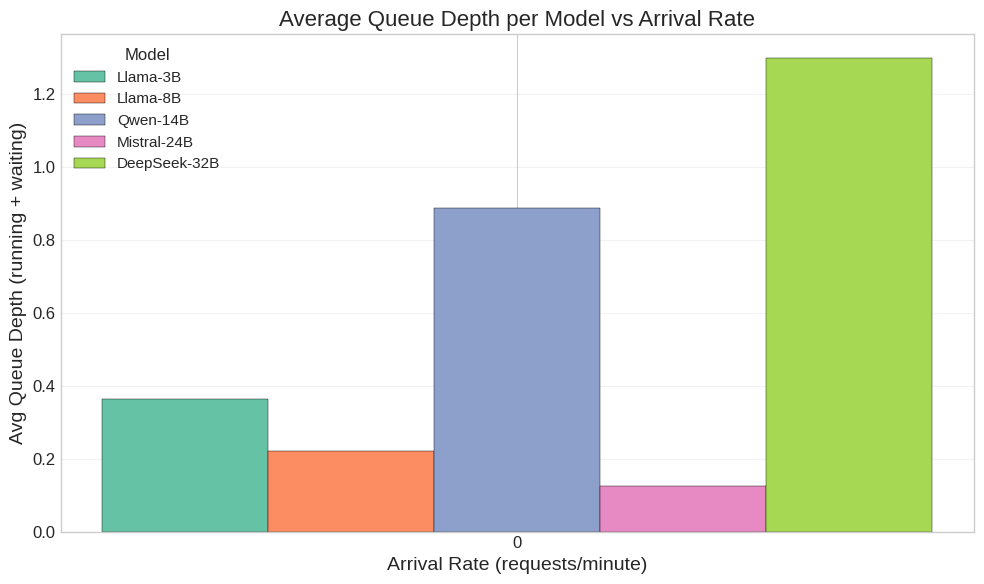

In [5]:
# ── Figure 1: Average Queue Depth per Model vs Arrival Rate ──
# Queue depth = llm_running + llm_waiting (vLLM metrics snapshot before each request)

queue_stats = (
    step_df.groupby(['arrival_rate', 'model_short'])['queue_depth']
    .mean()
    .reset_index()
)
queue_pivot = (
    queue_stats.pivot(index='arrival_rate', columns='model_short', values='queue_depth')
    .reindex(columns=models_in_data)
)

colors = sns.color_palette('Set2', n_colors=len(models_in_data))
x = np.arange(len(arrival_rates))
bar_width = 0.8 / max(len(models_in_data), 1)

fig, ax = plt.subplots(figsize=(10, 6))
for i, model in enumerate(models_in_data):
    offset = (i - (len(models_in_data) - 1) / 2) * bar_width
    ax.bar(
        x + offset,
        queue_pivot[model].values,
        width=bar_width,
        label=model,
        color=colors[i],
        edgecolor='black',
        linewidth=0.3,
    )

ax.set_xlabel('Arrival Rate (requests/minute)')
ax.set_ylabel('Avg Queue Depth (running + waiting)')
ax.set_title('Average Queue Depth per Model vs Arrival Rate')
ax.set_xticks(x)
ax.set_xticklabels([str(int(r)) for r in arrival_rates])
ax.legend(title='Model', loc='upper left')
ax.grid(True, axis='y', alpha=0.25)
plt.tight_layout()
plt.show()

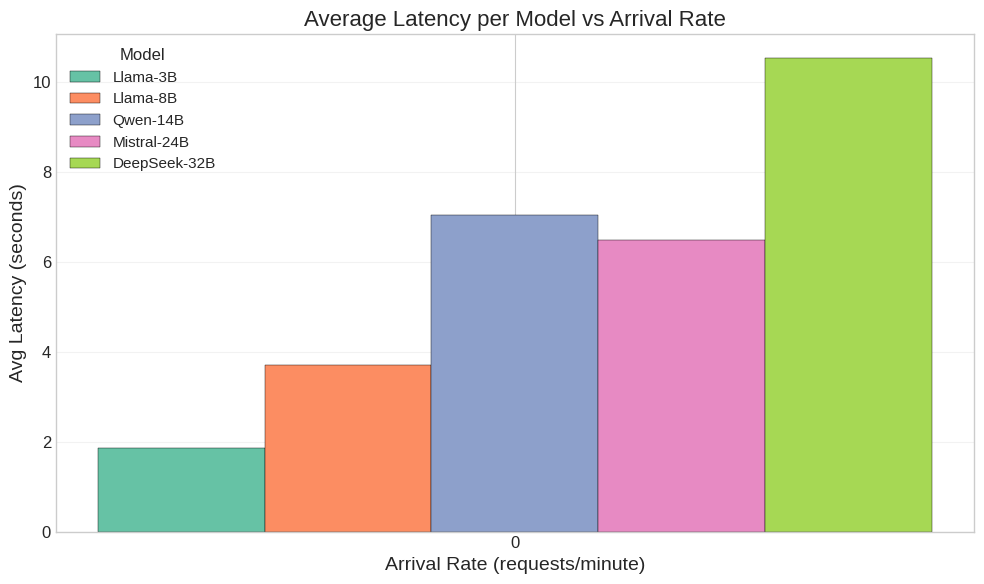

In [6]:
# ── Figure 2: Average Latency per Model vs Arrival Rate ──

latency_stats = (
    step_df.groupby(['arrival_rate', 'model_short'])['latency_seconds']
    .mean()
    .reset_index()
)
latency_pivot = (
    latency_stats.pivot(index='arrival_rate', columns='model_short', values='latency_seconds')
    .reindex(columns=models_in_data)
)

colors = sns.color_palette('Set2', n_colors=len(models_in_data))
x = np.arange(len(arrival_rates))
bar_width = 0.8 / max(len(models_in_data), 1)

fig, ax = plt.subplots(figsize=(10, 6))
for i, model in enumerate(models_in_data):
    offset = (i - (len(models_in_data) - 1) / 2) * bar_width
    vals = latency_pivot[model].values
    ax.bar(
        x + offset,
        vals,
        width=bar_width,
        label=model,
        color=colors[i],
        edgecolor='black',
        linewidth=0.3,
    )

ax.set_xlabel('Arrival Rate (requests/minute)')
ax.set_ylabel('Avg Latency (seconds)')
ax.set_title('Average Latency per Model vs Arrival Rate')
ax.set_xticks(x)
ax.set_xticklabels([str(int(r)) for r in arrival_rates])
ax.legend(title='Model', loc='upper left')
ax.grid(True, axis='y', alpha=0.25)
plt.tight_layout()
plt.show()

# Per-Role Latency vs Arrival Rate Plots

Found 12 unique roles: ['AlgorithmEngineer', 'CertifiedAccountant', 'Economist', 'Engineer', 'Inspector', 'MathAnalyst', 'MathSolver', 'MathTeacher', 'Mathematician', 'ProgrammingExpert', 'Scientist', 'SoftwareDeveloper']

Role: AlgorithmEngineer
  Models: ['DeepSeek-32B', 'Llama-3B', 'Llama-8B', 'Mistral-24B']
  Data points: 4


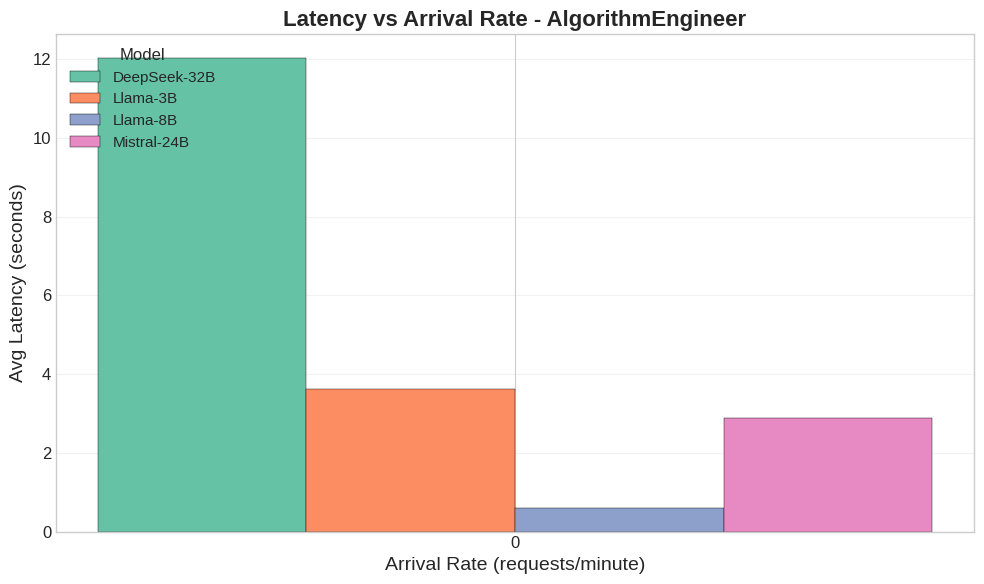


Role: CertifiedAccountant
  Models: ['DeepSeek-32B', 'Llama-3B', 'Llama-8B', 'Qwen-14B']
  Data points: 6


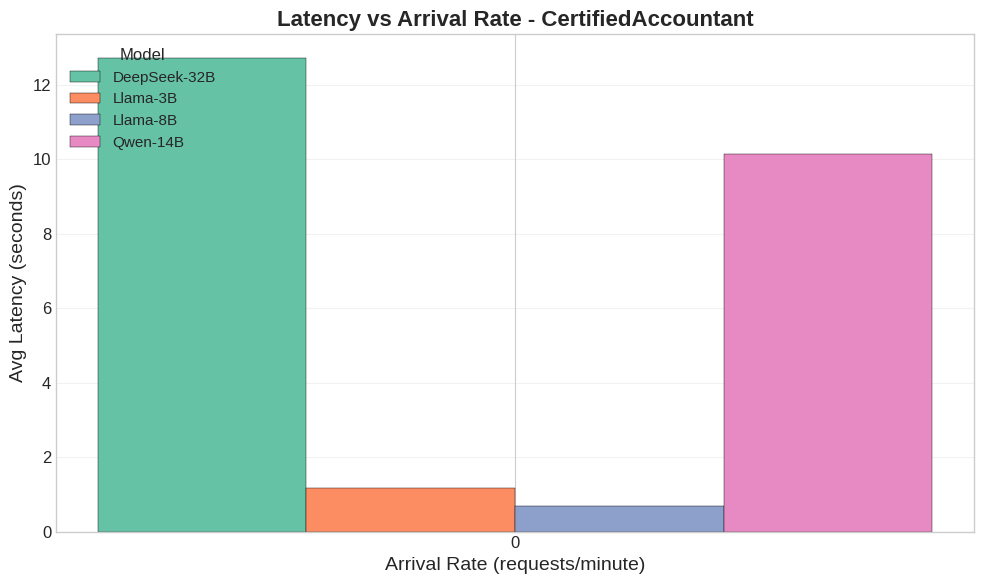


Role: Economist
  Models: ['DeepSeek-32B', 'Mistral-24B']
  Data points: 2


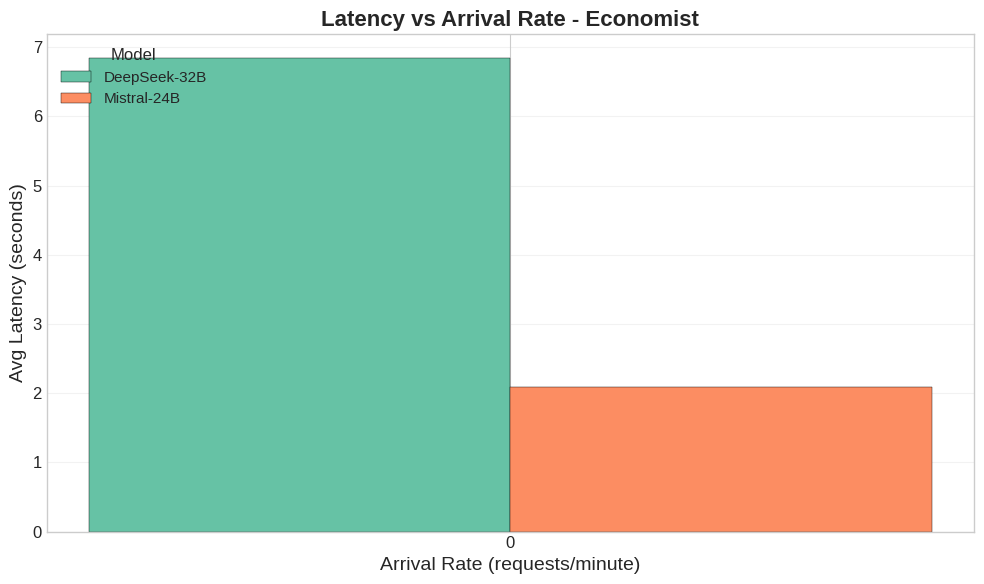


Role: Engineer
  Models: ['DeepSeek-32B', 'Mistral-24B']
  Data points: 3


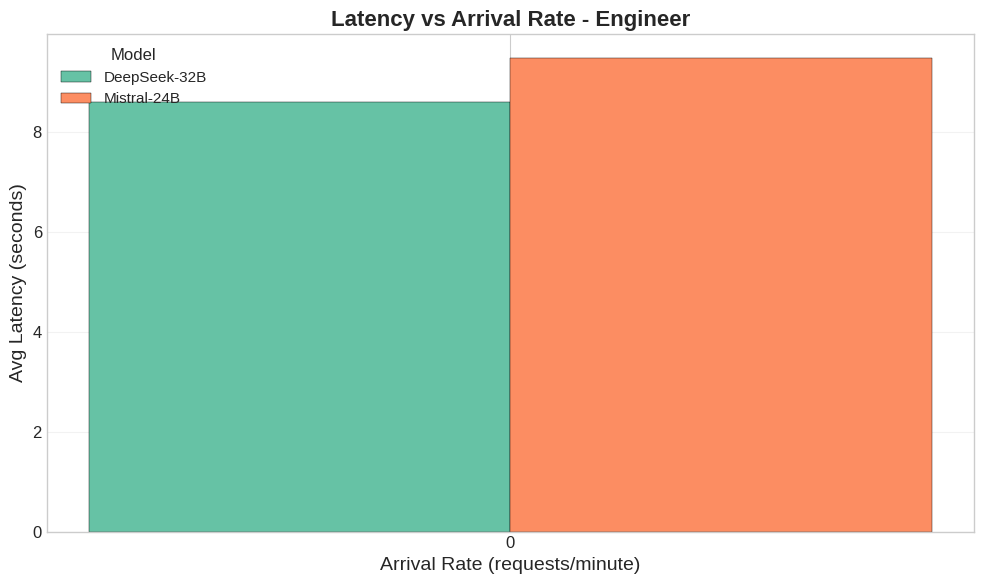


Role: Inspector
  Models: ['Qwen-14B']
  Data points: 2


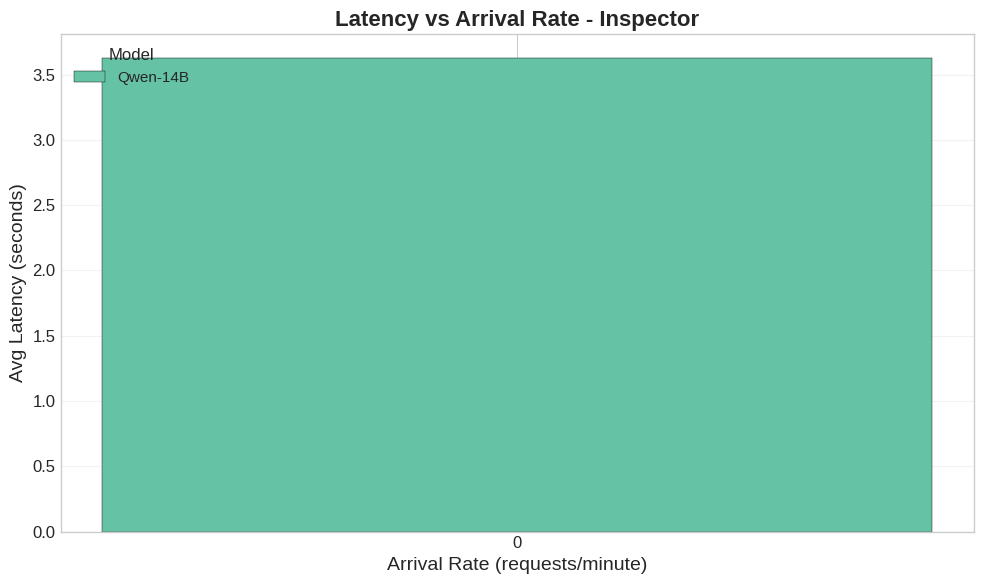


Role: MathAnalyst
  Models: ['Mistral-24B']
  Data points: 1


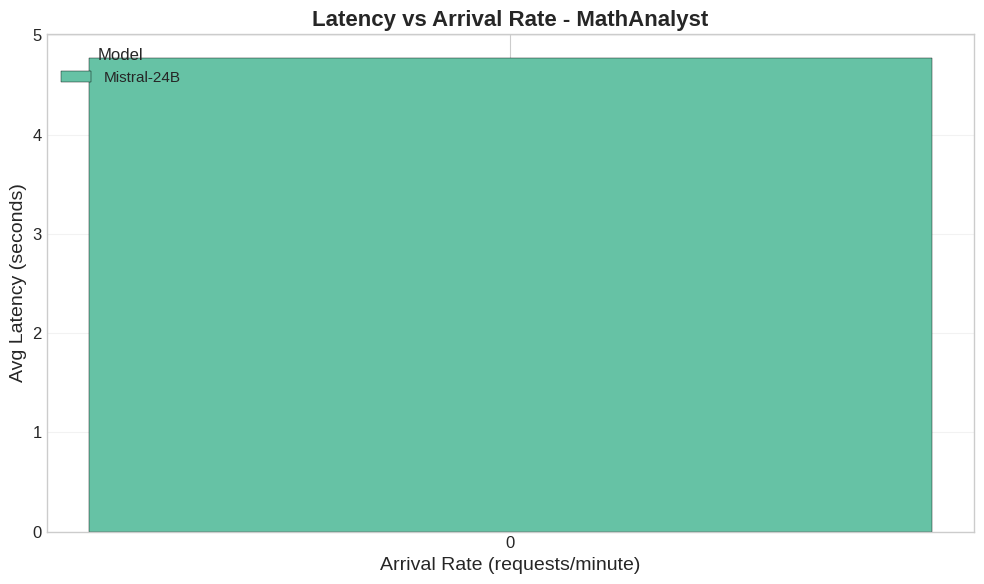


Role: MathSolver
  Models: ['Llama-8B', 'Mistral-24B', 'Qwen-14B']
  Data points: 3


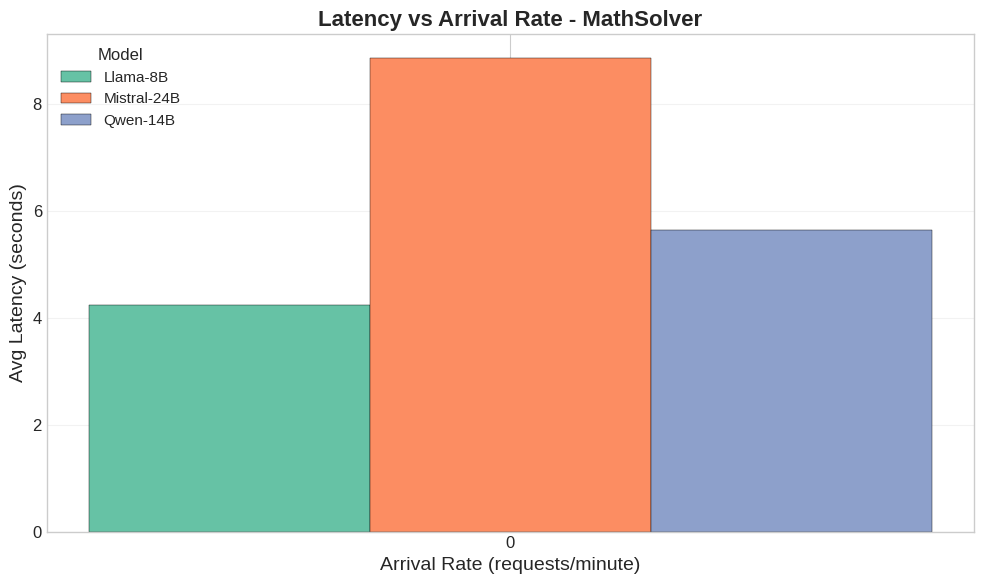


Role: MathTeacher
  Models: ['DeepSeek-32B', 'Llama-3B', 'Llama-8B', 'Qwen-14B']
  Data points: 6


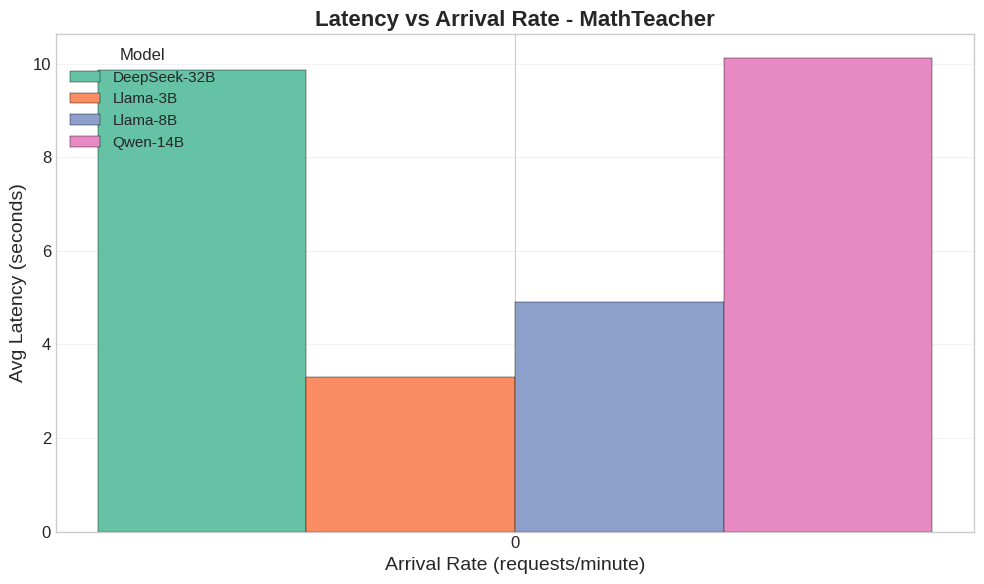


Role: Mathematician
  Models: ['Llama-3B']
  Data points: 1


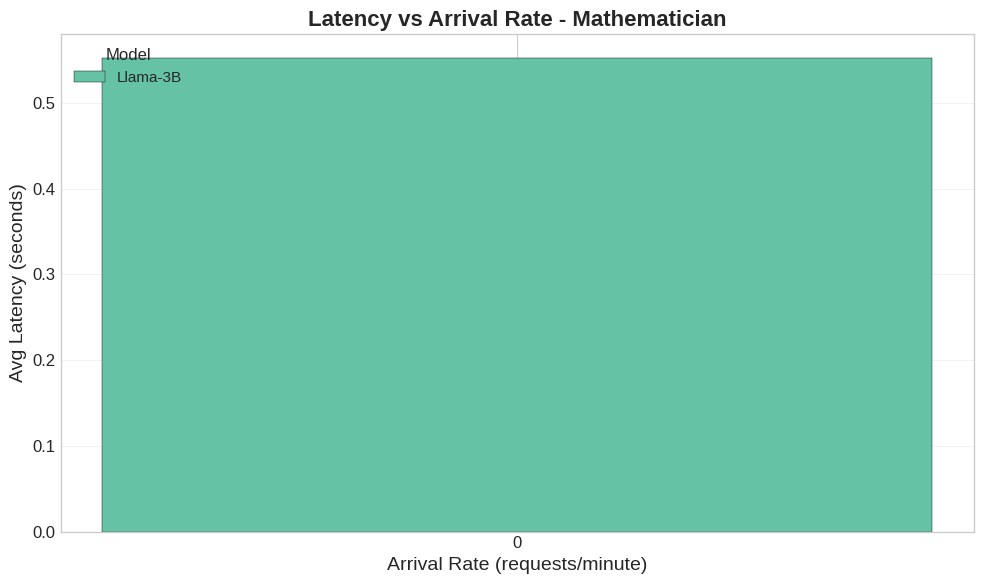


Role: ProgrammingExpert
  Models: ['DeepSeek-32B', 'Llama-3B', 'Llama-8B', 'Qwen-14B']
  Data points: 8


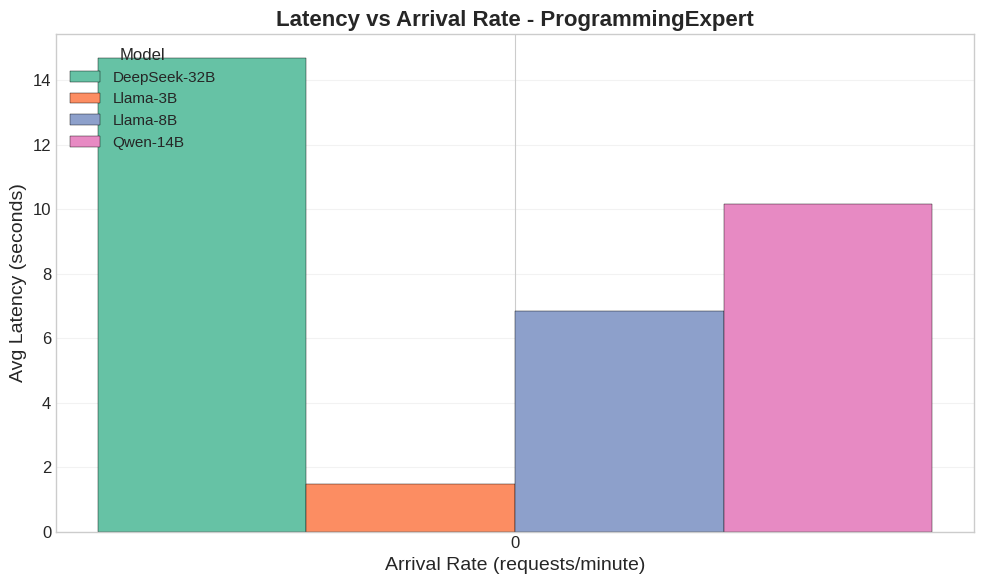


Role: Scientist
  Models: ['DeepSeek-32B', 'Llama-3B']
  Data points: 4


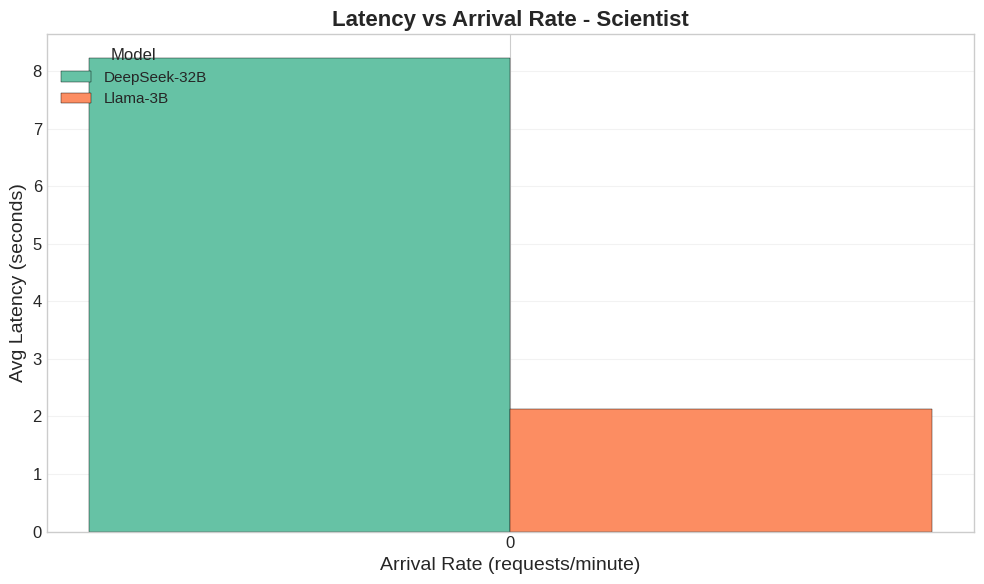


Role: SoftwareDeveloper
  Models: ['DeepSeek-32B', 'Llama-3B', 'Llama-8B', 'Mistral-24B', 'Qwen-14B']
  Data points: 7


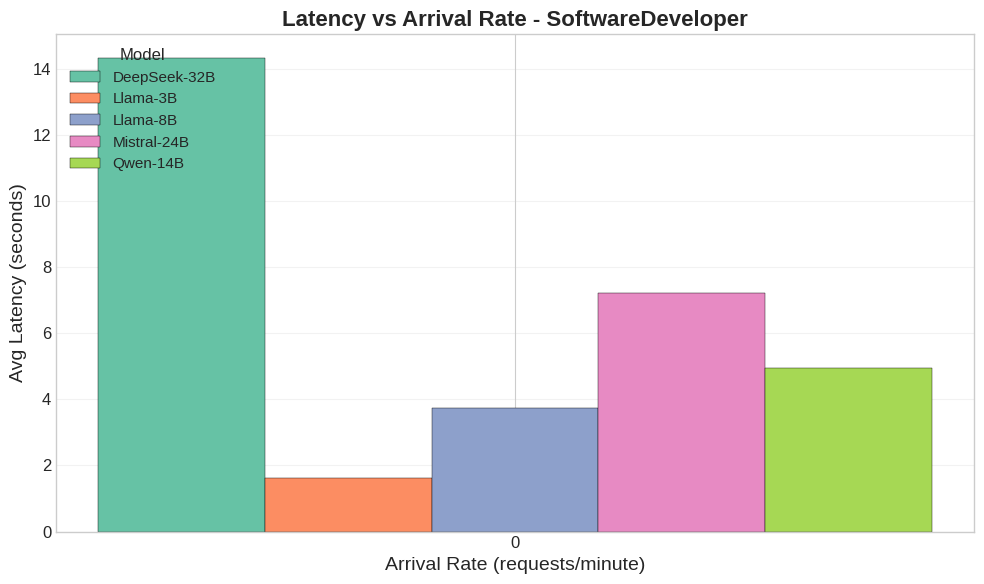

In [8]:
# ── Figure 3+: Average Latency vs Arrival Rate per Role ──
# Create one plot per role showing all models used with that role

# Get unique roles (excluding NaN)
roles = sorted([r for r in step_df['role_name'].dropna().unique() if pd.notna(r)])

print(f'Found {len(roles)} unique roles: {roles}\n')

# Generate one plot per role
for role in roles:
    # Filter data for this role
    role_df = step_df[step_df['role_name'] == role].copy()
    
    if len(role_df) == 0:
        print(f'No data for role: {role}')
        continue
    
    # Get models used with this role
    role_models = sorted([m for m in role_df['model_short'].dropna().unique()])
    
    if len(role_models) == 0:
        print(f'No models found for role: {role}')
        continue
    
    print(f'Role: {role}')
    print(f'  Models: {role_models}')
    print(f'  Data points: {len(role_df)}')
    
    # Compute latency stats per model and arrival rate
    latency_stats = (
        role_df.groupby(['arrival_rate', 'model_short'])['latency_seconds']
        .mean()
        .reset_index()
    )
    
    # Create pivot table
    latency_pivot = (
        latency_stats.pivot(index='arrival_rate', columns='model_short', values='latency_seconds')
    )
    
    # Get arrival rates for this role
    role_arrival_rates = sorted(latency_pivot.index.dropna().unique())
    
    # Create the plot
    colors = sns.color_palette('Set2', n_colors=len(role_models))
    x = np.arange(len(role_arrival_rates))
    bar_width = 0.8 / max(len(role_models), 1)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for i, model in enumerate(role_models):
        if model not in latency_pivot.columns:
            continue
        offset = (i - (len(role_models) - 1) / 2) * bar_width
        vals = latency_pivot[model].values
        ax.bar(
            x + offset,
            vals,
            width=bar_width,
            label=model,
            color=colors[i % len(colors)],
            edgecolor='black',
            linewidth=0.3,
        )
    
    ax.set_xlabel('Arrival Rate (requests/minute)', fontsize=14)
    ax.set_ylabel('Avg Latency (seconds)', fontsize=14)
    ax.set_title(f'Latency vs Arrival Rate - {role}', fontsize=16, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([f'{int(r)}' for r in role_arrival_rates])
    ax.legend(title='Model', loc='upper left', fontsize=11)
    ax.grid(True, axis='y', alpha=0.25)
    plt.tight_layout()
    
    plt.show()
    print()